AE model hash: 0vv91BKH/BA6h2+yR3Ds4A==
audio: /work/Clustering+WWD/non_ww_speakers_short/1705/142318/1705-142318-0038.wav
bottleneck max: 1.1630746126174927


/home/student/anaconda3/envs/student/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


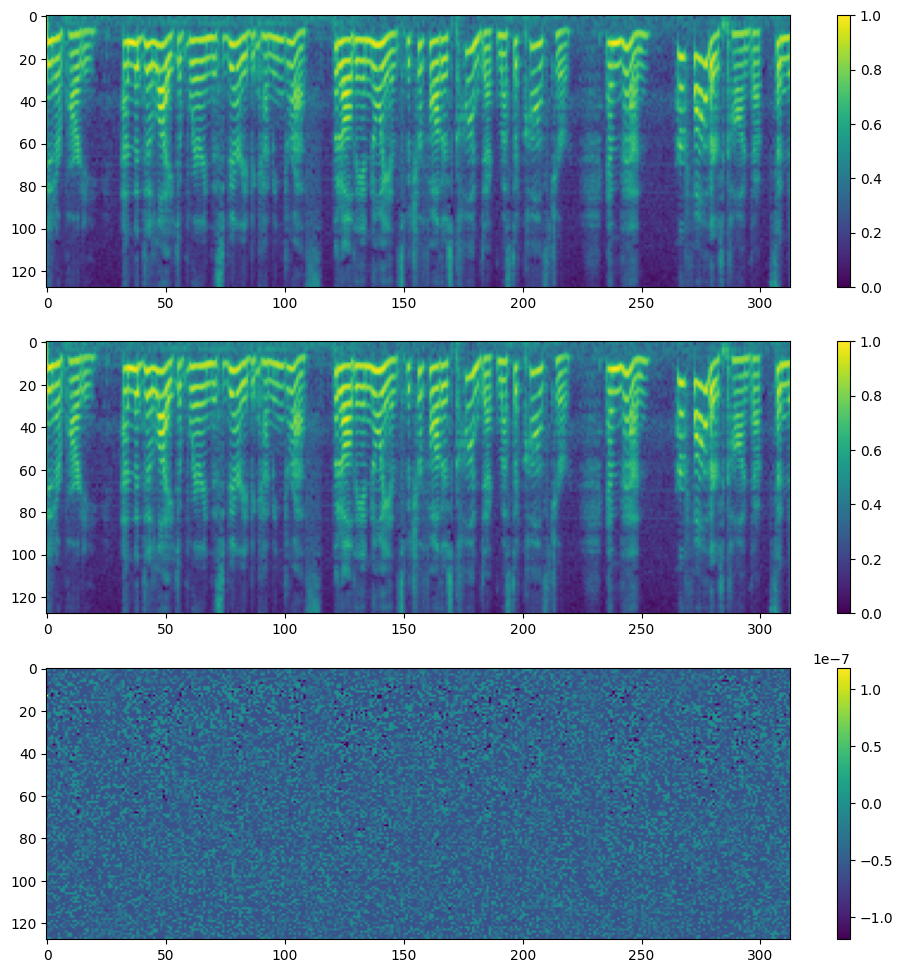

In [11]:
import numpy as np
import torch
import ConvAutoEncoder
from utilities import lmbe, model_hash
import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt

def feature_extraction(node_signal_tensor, fs, AE, exp=0, cluster=0, is_target=False): #pro sample 4x feature extraction
    num_nodes = node_signal_tensor.size(0)
    highlevel_tensor = torch.zeros((num_nodes, 280))
    for n in range(num_nodes):
        node_signal = node_signal_tensor[n,:]
        lmbe_spectogram = lmbe(node_signal, fs)
        AE.encode_only()
        highlevel = AE(lmbe_spectogram.unsqueeze(0).narrow(2,0,312))
        highlevel_tensor[n,:] = highlevel
    output = highlevel_tensor
    #if not is_target:
    #    output = utilities.feature_fusion(exp, cluster, highlevel_tensor)
    return output

#ae = torch.load('AE_BA_trained_280')
ae = ConvAutoEncoder.Mel_AutoEncoder_280()
ae.load_state_dict(torch.load('/home/student/Desktop/Code_BA_Intek/Trainierte Modelle/AE280_final'))
print(f'AE model hash: {model_hash(ae)}')

audio_0_path = '/work/Clustering+WWD/non_ww_speakers_short/1705/142318/1705-142318-0038.wav'
print(f"audio: \033[0;34m{audio_0_path}\033[0m")
audio_0 = np.zeros((1,160000))
audio_1 = np.zeros((1,160000))
audio_0[0,:159999] = wavfile.read('/home/student/Desktop/Code_BA_Intek'+audio_0_path)[1]
audio_1[0,:159999] = librosa.load('/home/student/Desktop/Code_BA_Intek'+audio_0_path, sr=16e3)[0]


signal = (audio_1[0] * 32767).astype(np.int16)
wavfile.write('./temp.wav', 16000, signal)
#print(audio_0.shape, audio_0.min(), audio_0.max(), audio_0.dtype)
lmbe_0 = lmbe(torch.Tensor(audio_0), sr=16e3)
#print(lmbe_0.size(), lmbe_0.min(), lmbe_0.max())
lmbe_1 = lmbe(torch.Tensor(audio_1), sr=16e3)

ae.encode_only()
#bn = ae(lmbe_0.narrow(2,0,312))
bn = ae(lmbe_1.narrow(2,0,312))

signal_tensor = torch.zeros((1,160000))
signal_tensor[0] = signal_tensor[0] + torch.Tensor(audio_1[0:160000])
bn_util = feature_extraction(signal_tensor, 16e3, ae)

print(f'bottleneck max: {bn.max()}')

np.save('/home/student/Documents/WHK_Projekt_1/code_ID/bn_util_debug.npy', bn_util.squeeze().detach().numpy())

plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.imshow(lmbe_0.squeeze(), aspect='auto')
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(lmbe_1.squeeze(), aspect='auto')
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow(lmbe_1.squeeze()-lmbe_0.squeeze(), aspect='auto')
plt.colorbar()
plt.show()


In [4]:
def bottleneck_from_dir(dir:str):
    ae = ConvAutoEncoder.Mel_AutoEncoder_280()
    ae.load_state_dict(torch.load('/home/student/Desktop/Code_BA_Intek/Trainierte Modelle/AE280_final'))
    ae.encode_only()
    audio = np.zeros((1,160000))
    audio[0,:159999] = librosa.load('/home/student/Desktop/Code_BA_Intek'+dir, sr=16e3)[0]
    spectrogram = lmbe(torch.Tensor(audio), sr=16e3)
    bottleneck = ae(spectrogram.narrow(2,0,312))
    return bottleneck.squeeze()